# PROPORTION SEVERE

In a setting such as a refugee setting we will assume hospitalization will be limited to those who most require it, specifically severe cases. We assume all hospitalization capacity available will be shifted for responding to COVID-19 severe cases, and no hospitalization for purposes of isolation will be done. Under these assumptions, we can assume the proportion of infections that result in severe disease approximate the proportion that will require hospitalization.

While we are still trying to understand who is most at risk for severe disease and what proporiton of individuals infected will eventually develop severe disease and die, we do know that this is highly dependent on age. To get an appropriate estimate of severity in different populations, we will use estimates of proportion severe by age to adjust by the populations age distribution and get an overall proportion severe for the population of interest.

We will use bayesian methods to estimate the proportion severe by age, using data from Shenzhen, China (Bi et al. 2020).

In [1]:
import pandas as pd
severe_age_prob=pd.read_csv('R/data/severe_age_prob.csv')

In [3]:
severe_age_prob.head()

,1,2,3,4,5,6,7,8
0,0.05,0.083333,0.000000,0.034483,0.066667,0.054054,0.209302,0.000000
1,0.05,0.083333,0.000000,0.011494,0.083333,0.067568,0.313953,0.055556
2,0.00,0.000000,0.029412,0.011494,0.016667,0.094595,0.406977,0.166667
3,0.00,0.000000,0.000000,0.000000,0.016667,0.054054,0.186047,0.166667
4,0.05,0.000000,0.000000,0.011494,0.150000,0.081081,0.186047,0.055556


The age distribution for moria camp is:
Age breakdown within the camp (20,000 people)
50+ 4.7%
19-49 54.8%
0-18 40.5%

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate
import numpy as np

In [8]:
#fit a smooth spline to the age mid and percentage of age per year
moria_age={
    'age':['0-18 yr','19-49 yr','50-70 yr'],'n_years':[18,30,20],'mid':[9,34,60],'total':[0.405,0.548,0.047]
}
moria_age_frame=pd.DataFrame.from_dict(moria_age)
moria_age_frame['total_per_year']=moria_age_frame['total']/moria_age_frame['n_years']
#save the age csv
moria_age_frame.to_csv('moria_age_distribution.csv')
f = interpolate.interp1d(moria_age_frame['mid'], moria_age_frame['total_per_year'],kind='slinear',fill_value='extrapolate')
xnew = np.arange(0, 70, 1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(moria_age_frame['mid'], moria_age_frame['total_per_year'], 'o', xnew, ynew, '-')
plt.show()

In [24]:
#group ynew into 10 year age bucket and get the severtity of each 10-year bucket

In [111]:
ynew[ynew<0]=0
age_fit={
    'age':xnew,'prop':ynew
}
moria_age_fit=pd.DataFrame.from_dict(age_fit)
moria_age_fit['age10']=np.floor(moria_age_fit['age']/10)*10
age10_prop=moria_age_fit.groupby('age10').sum()['prop']
age10_prop=age10_prop/age10_prop.sum()
age_prop=age10_prop.values
age_prop=np.append(age_prop,0)
weighted_severe_age=np.zeros(severe_age_prob.values.shape)
i=0
for row in severe_age_prob.values:
    weighted_severe_age[i]=row*age_prop
    i+=1
p_severe_moria=np.sum(weighted_severe_age,axis=1)

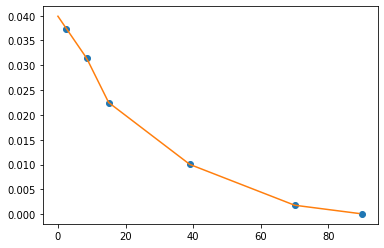

In [119]:
kutupalong_age=pd.read_csv('R/data/kutupalong/age_kutupalong.csv')
f = interpolate.interp1d(kutupalong_age['mid'], kutupalong_age['tot_per_year'],kind='slinear',fill_value='extrapolate')
xnew = np.arange(0, 90, 1)
ynew = f(xnew)   # use interpolation function returned by `interp1d`
plt.plot(kutupalong_age['mid'], kutupalong_age['tot_per_year'], 'o', xnew, ynew, '-')
plt.show()

In [126]:
ynew[ynew<0]=0
age_fit={
    'age':xnew,'prop':ynew
}
kutupalong_age_fit=pd.DataFrame.from_dict(age_fit)
kutupalong_age_fit['age10']=np.floor(kutupalong_age_fit['age']/10)*10
age10_prop=kutupalong_age_fit.groupby('age10').sum()['prop']
age10_prop=age10_prop/age10_prop.sum()
age_prop[7]=np.sum(age10_prop.values[7:])

In [129]:
weighted_severe_age=np.zeros(severe_age_prob.values.shape)
i=0
for row in severe_age_prob.values:
    weighted_severe_age[i]=row*age_prop
    i+=1
p_severe_kutupalong=np.sum(weighted_severe_age,axis=1)

In [130]:
import matplotlib.pyplot as plt

{'whiskers': [<matplotlib.lines.Line2D at 0x125b29690>,
 'caps': [<matplotlib.lines.Line2D at 0x125a3d990>,
 'boxes': [<matplotlib.lines.Line2D at 0x125b29cd0>,
 'medians': [<matplotlib.lines.Line2D at 0x125b357d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x125b3b610>,
 'means': []}

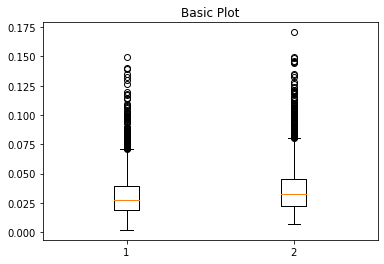

In [131]:
data=[p_severe_moria,p_severe_kutupalong]
fig1, ax1 = plt.subplots()
ax1.set_title('Basic Plot')
ax1.boxplot(data)

In [85]:
from scipy.stats import gamma

In [86]:
fit_alpha, fit_loc, fit_beta=gamma.fit(p_severe_)

# Stochastic SEIR

In [135]:
initial_state={'S':999, 'E':1, 'I1':0, 'I2':0, 'I3':0, 'R':0, 'I_trk':0, 'E_trk':0}

In [206]:
y=np.fromiter(initial_state.values(), dtype=int)

In [281]:
def runStochasticSEIR(beta=.001,
                              sigma=.5,
                              gamma=.05,
                              initial_state={'S':999, 'E':1, 'I1':0, 'I2':0, 'I3':0, 'R':0, 'I_trk':0, 'E_trk':0},
                              step_size = 1/4,
                              freq_dependent=False,
                              final_only=False,
                              max_time = float('Inf')):
    """
    Runs a simple stochastic SIR model.
    Parameters
     beta - the force of infection
     gamma - the recovery rate
     initial.state - the initial state of the system.
                  MUST BE WHOLE NUMBERS!
     time.step -  what time step should we use
     freq.dependent - should we use a frequency or densitiy
                dependent model
     final.only - speeds things up a little if we are only interested in
              the final state of the epidemic
     import - a vector showing number of importations into the sink
     import.step.size - time step of the importations
     import.step.size / step.size has to be an integer, same for step.size/import.step.size
     max.time - how many days of data do we ask the model to generate
    Returns
      a matrix with 4 columns: t, S, I, and R
    """
    if freq_dependent:
        beta_divisor=sum(initial_state.values())
    else:
        beta_divisor=1

    param={'beta':beta/beta_divisor, 'sigma':sigma, 'gamma':gamma}
    
    #Since we are not using a fancy solver we will need to run this on our own.
    #note that the epidemic ends once there are no more susceptibles.
    t = 0
    y = np.fromiter(initial_state.values(), dtype=float)
    
    
    sir_output = [np.insert(y, 0, t)]
  
  
    while (np.sum(y[1:5])>0 and t<=max_time ):
        t += step_size 
        
        delta = stochastic_dx_dt(step_size, y, param)
        
        # how y changes for each step.size increment
        y += np.squeeze(delta)
    
        #trick to speed up the code
        if not final_only: 
            sir_output=np.append(sir_output,[np.insert(y, 0, t)],axis=0)
        
    if final_only:
        sir_output = [np.insert(y, 0, t)]
    
#     colnames(sir.output) <- c("time", "S","E","I1","I2","I3","R","I_trk","E_trk")
    return sir_output



In [287]:
def stochastic_dx_dt(step_size, y, param):
    """
    The dx.dt method for a stochastic SIR using simple
    rates (e.g., a constant probability of being moved
    from one comparment to the other)

    Parameters:
     step.size -  the size of the step being taken compared
            to that used to specify the parameters

     y - the current state of the system.
     param - the parameters of the system

    Returns:
     a list representing the changes in each compartment of the system
    """
    #calculate the probability of infection and recovery
    #in this time step
    p_expose=1-np.exp(-step_size*param["beta"]*np.sum(y[2:5]))    
    p_infect=1-np.exp(-step_size*param["sigma"])        
    p_recover=1-np.exp(-step_size*param["gamma"])      

    #Do our random stuff so we know how much to change.
    # The number of exposed cases follows a binomial
    # distribution where N=S and p=p.exposed
    expose_cases=np.random.binomial(y[0],p_expose, 1)
  
    # The number of incident cases follows an erlang/gamma
    # to get that, we use 3 compartments with binomial
    # distribution where N=E and p=p.infect, 
    incident1_cases = np.random.binomial(y[1],p_infect, 1)

    # The number of recovered cases follows a binomial
    # distribution where N=I and p=p.recover
    incident2_cases = np.random.binomial(y[2], p_recover, 1)
    incident3_cases = np.random.binomial(y[3], p_recover, 1)
  
    # The number of recovered cases follows a binomial
    # distribution where N=I and p=p.recover
    recovered_cases = np.random.binomial(y[4], p_recover, 1)
  
  
    #Find the deltas for our compartments
    dS  = -expose_cases
    dE  = expose_cases - incident1_cases
    dI1 = incident1_cases - incident2_cases
    dI2 = incident2_cases - incident3_cases
    dI3 = incident3_cases - recovered_cases
    dR  = recovered_cases 
    dI_trk = incident1_cases
    dE_trk = expose_cases
  
    #Those susceptibles move to the recovered compartment
    return np.array([dS,dE,dI1,dI2,dI3,dR,dI_trk,dE_trk])

In [290]:
sir_output=runStochasticSEIR(freq_dependent=True)

In [291]:
sir_output

array([[0.0000e+00, 9.9900e+02, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.5000e-01, 9.9900e+02, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.0000e-01, 9.9900e+02, 1.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [2.1300e+02, 9.9900e+02, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.1325e+02, 9.9900e+02, 0.0000e+00, ..., 0.0000e+00, 1.0000e+00,
        0.0000e+00],
       [2.1350e+02, 9.9900e+02, 0.0000e+00, ..., 1.0000e+00, 1.0000e+00,
        0.0000e+00]])

In [300]:
days_m1 = days[1:]

In [303]:
new_cases=np.diff(sir_output[:,-2])

In [305]:
len(new_cases)

854

In [308]:
len(days_m1)

854

In [309]:
epi_df = pd.DataFrame({'day':days_m1 ,'data': new_cases}, columns=['day', 'data'])

In [316]:
epi_df.groupby('day').sum()['data'].values

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [320]:
r0 =[2.68,2.24,0.3,1.44,2.1,3.2,7.05,2.4,2.4,4.7,6.6,3.24,2.45,1.48,3.1,1.6,3.11,2.5,2.6,2.2]

# Simulation specifics   ----------------------------------------------
n_sims = 50 # simulations per R
n_Rs = 20
run_time = 550
start_date_= "2020-03-15"
end_date = "2022-01-01"
step_size = 1/8
seeds = 1
cores = 4

# Population Size - Kutupalong camp
N = 600000

# Transmission Characteristics ---------------------------------
# we are going to assume recovery has mean of 7 days from infection
# then we will use a beta consistent with our estimates from above
# https://github.com/midas-network/COVID-19/tree/master/parameter_estimates/2019_novel_coronavirus

# incubation period 5.2 days based on an estimate from Lauer et al. 2020
sigma = 1/(5.2) # subtract 1 for latent period adjustment
# time from symptom onset to recovery  
n_Icomp = 3 # number of I compartments (using 3 to capture Erlang distribution)
gamma =  1/6 * n_Icomp 

# R0 Values  ----------------------------------------------

# Controlled transmission 
R0_low = np.random.uniform(1.5,2,n_Rs)
# Moderate transmission
R0_mid = np.random.uniform(2,3,n_Rs)
# Inflated transmission (inflated by the diphtheria inflation factor)
R0_high = np.random.uniform(2*1.65,3*1.65,n_Rs)

betas_low = R0_low   * gamma / n_Icomp
betas_mid = R0_mid   * gamma / n_Icomp
betas_high = R0_high * gamma / n_Icomp

# Hospitalization   ----------------------------------------------

# time from hospitalization to discharge mean= 11.5, sd=3.625
# time from hospitalization to death mean= 11.2, sd= 1.88
# Time to hospitalization among symptom-based, mean 4.65 days (95% CI 0.93-12.42) (Bi et al. 2020)
# Time from hospitalization to discharge,  11.5 days (95% CI 8.0-17.3) (Sanche et al. 2020)
# Time from hospitalization to death, 11.2 days (95% CI 8.7-14.9) (Sanche et al. 2020)

#p_hosp  <- c(p_severe_kutupalong, p_hosp_kutupalong_high)
p_death = .1
p_ICU   = 0.264
p_vent  = 0.15

time_hosp_pars = [1.23, 0.79]
time_death_pars = [np.log(11.25), np.log(1.15)]
time_disch_pars = [np.log(11.5), np.log(1.22)]

In [371]:
betas = betas_low
sim_res = run_seir_model()

100%|██████████| 20/20 [00:44<00:00,  2.22s/it]


In [372]:
sim_res

,index,sim,beta_ind,beta,day,seeds,incid,exposed,cum_exposed,cum_cases,date
0,0,0,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
1,1,1,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
2,2,2,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
3,3,3,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
4,4,4,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]",1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
...,...,...,...,...,...,...,...,...,...,...,...
395,15,15,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
396,16,16,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
397,17,17,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."
398,18,18,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 3.0, 3.0, 3.0, 3.0, ...","[0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 3.0, ...","DatetimeIndex(['2020-04-16', '2020-04-17', '20..."


In [341]:
start_date = pd.Series([start_date_]*sim_res.shape[0])

In [344]:
start_date = pd.to_datetime(start_date,format='%Y-%m-%d');start_date

0     2020-03-15
1     2020-03-15
2     2020-03-15
3     2020-03-15
4     2020-03-15
         ...    
395   2020-03-15
396   2020-03-15
397   2020-03-15
398   2020-03-15
399   2020-03-15
Length: 400, dtype: datetime64[ns]

In [349]:
new_day=[]
for array in sim_res['day']:
    new_day.append(pd.to_timedelta(array,unit='day'))

In [365]:
date=[]
for x,y in zip(new_day,start_date):
    date.append(x+y)

In [366]:
sim_res['date']=date

In [367]:
sim_res

,sim,beta_ind,beta,day,seeds,incid,exposed,cum_exposed,cum_cases,date
0,0,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
1,1,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 2.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 2.0, 2.0, 4.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, 3.0, 3.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
2,2,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
3,3,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 2.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 2.0, 3.0, 5.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 2.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
4,4,0,0.305915,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
...,...,...,...,...,...,...,...,...,...,...
15,15,19,0.258908,"[0.0, 1.0, 2.0, 3.0]",1,"[1.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0]","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
16,16,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0]",1,"[1.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 0.0]","[1.0, 1.0, 1.0, 1.0, 1.0]","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
17,17,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."
18,18,19,0.258908,"[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, ...",1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","DatetimeIndex(['2020-03-15', '2020-03-16', '20..."


In [370]:
from tqdm import tqdm

def run_seir_model(n_sims=20, N=600000, betas=betas_low, sigma=sigma, gamma=gamma, seeds=1, start_date_="2020-04-16", step_size=.25, run_time=360):
    
    sim_res = []
    
    for b in tqdm(range(len(betas))):
        sim_res_sim = []
        
        for i in range(n_sims):
            tmp = runStochasticSEIR(beta = betas[b],
                                    sigma = sigma,
                                    gamma = gamma,
                                    initial_state = {'S':N-seeds, 'E':seeds, 'I1':0, 'I2':0, 'I3':0, 'R':0, 'I_trk':0, 'E_trk':0},
                                    step_size = step_size,
                                    freq_dependent = True,
                                    final_only = False,
                                    max_time = run_time)
            
            # get epi curve by aggregtating 
            new_cases=np.diff(tmp[:,-2])
            new_exposed=np.diff(tmp[:,-1])
            
            days = np.floor(tmp[:,0])
            days_m1 = days[1:]
            epi_df = pd.DataFrame({'day':days_m1 ,'data': new_cases}, columns=['day', 'data'])
            epi_curve = epi_df.groupby('day').sum()['data'].values # sum up time steps by day
            inf_df = pd.DataFrame({'day':days_m1 ,'data': new_exposed}, columns=['day', 'data'])
            inf_curve = inf_df.groupby('day').sum()['data'].values # sum up time steps by day
            
            sim_res_sim.append({'sim':i, 'beta_ind':b, 'beta':betas[b], 
                                           'day':np.unique(days), 'seeds':seeds,
                                           'incid':epi_curve, 
                                           'exposed':inf_curve,
                                           'cum_exposed':np.cumsum(inf_curve),
                                           'cum_cases':np.cumsum(epi_curve)}
                                )
        
        
        sim_res.append(sim_res_sim)
    
    sim_frame_master=pd.DataFrame(sim_res[0])
    for i in range(1,len(sim_res)):
        sim_frame=pd.DataFrame(sim_res[i])
        sim_frame_master=pd.concat([sim_frame_master, sim_frame])
    sim_frame_master=sim_frame_master.reset_index()
    start_date = pd.Series([start_date_]*sim_frame_master.shape[0])
    start_date = pd.to_datetime(start_date,format='%Y-%m-%d')
    new_day=[]
    for array in sim_frame_master['day']:
        new_day.append(pd.to_timedelta(array,unit='day'))
    date=[]
    for x,y in zip(new_day,start_date):
        date.append(x+y)
    
    sim_frame_master['date']=date

#     sim_res <- sim_res %>% arrange(sim, beta) %>% 
#         mutate(sim_beta = paste0(sim, "-", beta_ind)) %>% 
#         mutate(sim_id = as.integer(as.factor(sim_beta)))
    
    return sim_frame_master
